# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, random, shutil
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image

In [1]:
conda install pytorch torchvision torchaudio cudatoolkit=11.1 -c pytorch -c conda-forge


Note: you may need to restart the kernel to use updated packages.
Solving environment: ...working... done

## Package Plan ##


  environment location: C:\Users\jones\anaconda3

  added / updated specs:
    - cudatoolkit=11.1
    - pytorch
    - torchaudio
    - torchvision


The following NEW packages will be INSTALLED:

  cudatoolkit        conda-forge/win-64::cudatoolkit-11.1.1-heb2d755_7
  libuv              conda-forge/win-64::libuv-1.42.0-h8ffe710_0
  ninja              conda-forge/win-64::ninja-1.10.2-h5362a0b_0
  pytorch            pytorch/win-64::pytorch-1.9.0-py3.8_cuda11.1_cudnn8_0
  torchaudio         pytorch/win-64::torchaudio-0.9.0-py38
  torchvision        pytorch/win-64::torchvision-0.10.0-py38_cu111


Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... "By downloading and using the CUDA Toolkit conda packages, you accept the terms and conditions of the CUDA End User License Agreement (EULA): https://d

### Dividing Dataset (70% training, 30% testing)

In [49]:
def img_train_test_split(root_dir, classes_dir, test_ratio):
    '''
    This function splits a folder with subfolders into train and test datasets
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images
    :param classes_dir: a list of strings of subfolder names
    :param test_ratio: a float of the ratio of test dataset to train dataset
    :return: None
    '''

    for cls in classes_dir:
        # create a new train and test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                   [int(len(allFileNames) * (1 - test_ratio))])

        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
    return None

In [ ]:
classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']
test_ratio = 0.3

In [ ]:
# root_dir: filepath of coad_msi_mss with '/' at the back
root_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

#root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'
#root_dir = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/'

In [ ]:
img_train_test_split(root_dir, classes_dir, test_ratio)

### Dividing Dataset (60% training, 20% validation, 20% testing)

In [2]:
def img_train_val_test_split(root_dir):

    classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']

    val_ratio = 0.20
    test_ratio = 0.20

    for cls in classes_dir:

        # Create Train / Val / Test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'val/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls  # Folder to copy images from


        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, val_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                                  [int(len(allFileNames) * (1 - (val_ratio + test_ratio))),
                                                                   int(len(allFileNames) * (1 - val_ratio)),
                                                                   ])
       
        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new validation folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'val/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
        
    return None

In [3]:
# root_dir: filepath of coad_msi_mss with '/' at the back
#root_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

#root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'
#root_dir = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/'
root_dir = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/'

In [4]:
img_train_val_test_split(root_dir)

### Data Augmentation and Normalization

In [5]:
data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_val = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

#root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/train'
#root_dir_train = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/train'
root_dir_train = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/train'

#root_dir_train = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

#root_dir_val = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/val'
#root_dir_val = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/val'
root_dir_val = 'C:/Users/jones/Desktop/cancer dataset/coad_msi_mss/val'

#root_dir_test = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'

In [6]:
train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
val_image_dataset = datasets.ImageFolder(root = root_dir_val, transform=data_transformation_val)

### Prepare DataLoader

In [7]:
trainloader = DataLoader(train_image_dataset, batch_size=128, shuffle=True)
valloader = DataLoader(val_image_dataset, batch_size=128, shuffle=True)

### Data Visualization (Display some images)

In [8]:
class_names = trainloader.dataset.classes

def show_images(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            
            # Convert to from tensor to numpy
            # Take its transpose because
            # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
            image = image.numpy().transpose((1, 2, 0))  # Set axes
            
            # Images were normalised earlier.
            # To show the image denormalise the images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)
            
            colour = 'green' if preds[i] == labels[i] else 'red'
            
            plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=colour)
        
    plt.tight_layout()
    plt.show()

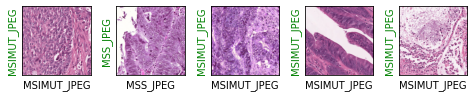

In [9]:
images, labels = next(iter(trainloader))

# Since predictions are not available for training data yet
# Labels are used in place of predictions
show_images(images, labels, labels)

### Creating Model - Load resnet18

In [10]:
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True)
#print(resnet18)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [12]:
# Freeze parameters so we don't backprop through them
for param in resnet18.parameters():
    param.requires_grad = False
    
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [12]:
class_names2 = trainloader.dataset.classes

def show_images2(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
                
            # Convert to from tensor to numpy
            # Take its transpose because
            # In ResNet implementation, the format for input is n_channels * n_height * n_width (!and not n_height * n_width * n_channels)
            image = image.numpy().transpose((1, 2, 0))  # Set axes
                
            # Images were normalised earlier.
            # To show the image denormalise the images
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
                
            image = image*std + mean
            image = np.clip(image, 0.,1.)
            plt.imshow(image)

            if preds[i] == 2:
                p = 1
            else:
                p = 0
            colour = 'green' if p == labels[i] else 'red'
                
            plt.xlabel(f'{class_names2[int(labels[i].numpy())]}')
            plt.ylabel(f'{class_names2[p]}', color=colour)
        
    plt.tight_layout()
    plt.show()

In [13]:
def show_preds():
    resnet18.eval()    # set to evaluation mode
    images, labels = next(iter(valloader))
    outputs = resnet18(images)
    _ , preds = torch.max(outputs, 1)
    #print(labels)
    show_images2(images, labels, preds)

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ../c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


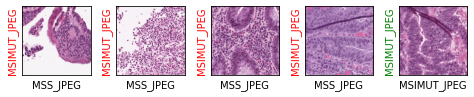

In [14]:
show_preds()

### Training Model

In [13]:
train_losses = []
train_acc = []

val_losses = []
val_acc = []

def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('--' * 5)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                condition = trainloader
                size = len(train_image_dataset)
            else:
                condition = valloader
                size = len(val_image_dataset)

            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in condition:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = running_loss / size
            epoch_acc = running_corrects.double() / size

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'val':
                val_losses.append(epoch_loss)
                val_acc.append(epoch_acc)
            else:
                train_losses.append(epoch_loss)
                train_acc.append(epoch_acc)
                
            # deep copy the model
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [14]:
num_epochs = 10
model_resnet18 = train_model(resnet18, loss_fn, optimizer, num_epochs)

Epoch 1/10
----------


C:\Users\jones\anaconda3\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


train Loss: 0.8051 Acc: 0.5958
val Loss: 0.7592 Acc: 0.5599

Epoch 2/10
----------
train Loss: 0.7187 Acc: 0.5989
val Loss: 0.7260 Acc: 0.5801

Epoch 3/10
----------
train Loss: 0.7017 Acc: 0.5931
val Loss: 0.7104 Acc: 0.5783

Epoch 4/10
----------
train Loss: 0.6843 Acc: 0.6060
val Loss: 0.6999 Acc: 0.5902

Epoch 5/10
----------
train Loss: 0.6772 Acc: 0.6090
val Loss: 0.6922 Acc: 0.6013

Epoch 6/10
----------
train Loss: 0.6694 Acc: 0.6241
val Loss: 0.6827 Acc: 0.5985

Epoch 7/10
----------
train Loss: 0.6583 Acc: 0.6275
val Loss: 0.6769 Acc: 0.6050

Epoch 8/10
----------
train Loss: 0.6527 Acc: 0.6327
val Loss: 0.6718 Acc: 0.6169

Epoch 9/10
----------
train Loss: 0.6489 Acc: 0.6440
val Loss: 0.6657 Acc: 0.6142

Epoch 10/10
----------
train Loss: 0.6422 Acc: 0.6431
val Loss: 0.6619 Acc: 0.6206

Training complete in 48m 8s
Best val Acc: 0.620626


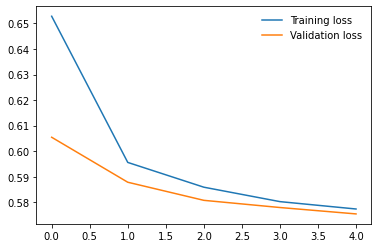

In [17]:
plt.plot(train_losses, label='Training loss')
plt.plot(val_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()

In [18]:
torch.save(model_resnet18, '/Users/vionnietan/Desktop/FIT3163 - FIT3164/FIT3164/FIT3164/resnet18.pth')

In [19]:
import pickle
filename = 'finalized_model.sav'
pickle.dump(model_resnet18,open(filename,'wb'))

In [20]:
pkl_filename = 'finalized_model.pkl'
with open(pkl_filename,'wb') as file:
    pickle.dump(model_resnet18,file)

In [ ]:
with open('model/finalized_model.pkl','rb') as file:
    model = pickle.load(file)
    